In [1]:
# Step 1: Importing the necessary libraries

import numpy as np
import sep
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Set up the display environment for Jupyter
%matplotlib inline


# Step 2: Loading the f105w Image
The Hubble Ultra Deep Field f105w image is loaded from a FITS file, and we visualize it to understand the data we're working with.


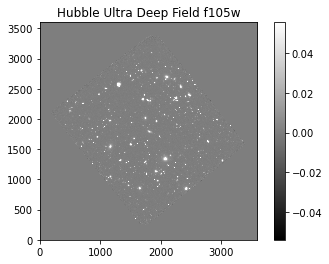

In [2]:
# Load the f105w FITS file
with fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits') as hdul:
    f105w_data = hdul[0].data
    # Ensure data is in native byte order
    if f105w_data.dtype.byteorder not in ('=', '|'):
        f105w_data = f105w_data.byteswap().newbyteorder()

# Display the f105w image
m_f105w, s_f105w = np.mean(f105w_data), np.std(f105w_data)
plt.figure()
plt.imshow(f105w_data, interpolation='nearest', cmap='gray', vmin=m_f105w-s_f105w, vmax=m_f105w+s_f105w, origin='lower')
plt.colorbar()
plt.title('Hubble Ultra Deep Field f105w')
plt.savefig('f105w_original.png')


# Step 3: Background Subtraction for the f105w Image
We subtract the background to facilitate the detection of objects in the f105w image.


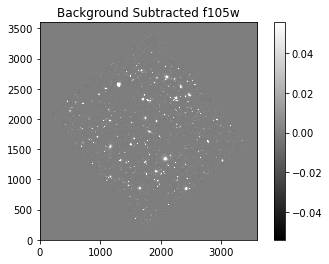

In [3]:
# Subtract the background
bkg = sep.Background(f105w_data)
f105w_data_sub = f105w_data - bkg

# Display the background-subtracted image
plt.figure()
plt.imshow(f105w_data_sub, interpolation='nearest', cmap='gray', vmin=m_f105w-s_f105w, vmax=m_f105w+s_f105w, origin='lower')
plt.colorbar()
plt.title('Background Subtracted f105w')
plt.savefig('f105w_background_subtracted.png')


# Step 4: Object Detection in the f105w Image
With the background subtracted, we can now run object detection on the f105w data.


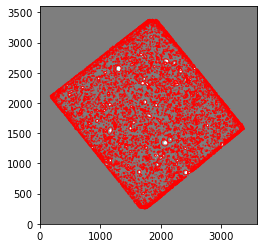

In [4]:
# Object detection
objects = sep.extract(f105w_data_sub, 1.5, err=bkg.globalrms)

# Display detected objects
fig, ax = plt.subplots()
m, s = np.mean(f105w_data_sub), np.std(f105w_data_sub)
im = ax.imshow(f105w_data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

# Plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]), width=6*objects['a'][i], height=6*objects['b'][i], angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('f105w_objects_detected.png')

# Step 5: Aperture Photometry on f105w Image
We will now perform aperture photometry on the detected objects to measure their properties such as flux.


In [5]:
# Aperture photometry
flux, fluxerr, flag = sep.sum_circle(f105w_data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

# Print out the flux for the first few objects
for i in range(10):  # Adjust this to view more or fewer objects
    print(f"Object {i}: flux = {flux[i]:.2f} +/- {fluxerr[i]:.2f}")


Object 0: flux = 0.03 +/- 0.18
Object 1: flux = 0.03 +/- 0.18
Object 2: flux = -0.02 +/- 0.00
Object 3: flux = 0.00 +/- 0.04
Object 4: flux = 0.01 +/- 0.11
Object 5: flux = -0.01 +/- 0.00
Object 6: flux = 0.03 +/- 0.17
Object 7: flux = -0.01 +/- 0.00
Object 8: flux = 0.05 +/- 0.22
Object 9: flux = 0.03 +/- 0.17


# Step 6: Additional Analysis of the f105w Image
We will now calculate additional statistics for the detected objects in the f105w image and create a histogram of their fluxes.


Mean flux: 0.36
Median flux: 0.03
Standard deviation of fluxes: 9.24
Largest outlier is 87.33 standard deviations from the mean


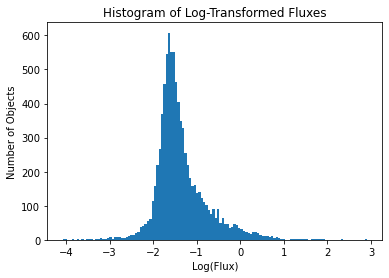

In [9]:
# Calculate and print out basic statistics of the detected objects' fluxes
mean_flux = np.mean(flux)
median_flux = np.median(flux)
std_flux = np.std(flux)
max_flux = np.max(flux)
max_flux_distance = (max_flux - mean_flux) / std_flux

print(f"Mean flux: {mean_flux:.2f}")
print(f"Median flux: {median_flux:.2f}")
print(f"Standard deviation of fluxes: {std_flux:.2f}")
print(f"Largest outlier is {max_flux_distance:.2f} standard deviations from the mean")

# Histogram the log-transformed fluxes
flux_nonzero = flux[flux > 0]  # Remove zero or negative flux values
log_flux = np.log10(flux_nonzero[~np.isnan(flux_nonzero)])  # Log-transform the flux values, remove NaNs

# Use automatic binning or manually define your bins based on the log-transformed flux range
plt.figure()
plt.hist(log_flux, bins='auto')
plt.xlabel('Log(Flux)')
plt.ylabel('Number of Objects')
plt.title('Histogram of Log-Transformed Fluxes')
plt.savefig('f105w_flux_histogram.png')  # Save the histogram as a PNG file



# Step 8: Creating a 3-Color False Image of the UDF
We will create a 3-color image using the f105w, f125w, and f160w bands from the Hubble Ultra Deep Field images.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


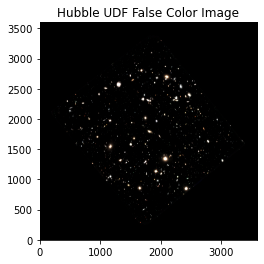

In [7]:
# Load f125w and f160w images and ensure byte order is native
with fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits') as hdul:
    f125w_data = hdul[0].data.byteswap().newbyteorder()

with fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits') as hdul:
    f160w_data = hdul[0].data.byteswap().newbyteorder()

# Scale the images to have similar intensity ranges for RGB channels
def scale_img(data):
    m, s = np.mean(data), np.std(data)
    return np.clip((data - m) / s, -1, 1)

# Create an RGB image
rgb = np.zeros((f105w_data.shape[0], f105w_data.shape[1], 3))
rgb[:, :, 0] = scale_img(f160w_data)  # Red channel
rgb[:, :, 1] = scale_img(f125w_data)  # Green channel
rgb[:, :, 2] = scale_img(f105w_data)  # Blue channel

# Display the RGB image
plt.figure()
plt.imshow(rgb, origin='lower')
plt.title('Hubble UDF False Color Image')
plt.savefig('hubble_udf_false_color.png')
